# Прогнозирование ингибирующей концентрации IC50

**Задача:** Построить модель машинного обучения для предсказания значения `IC50, mM` на основе физико-химических свойств соединений. IC50 (концентрация полумаксимального ингибирования) является ключевым показателем эффективности вещества как ингибитора.

**План работы:**
1. **Загрузка и обзор данных:** Изучение структуры и основных характеристик набора данных.
2. **Предварительная обработка данных:** Подготовка данных для моделирования, включая обработку пропусков и удаление неинформативных признаков.
3. **Исследовательский анализ данных (EDA):** Анализ распределения целевой переменной.
4. **Подготовка данных для моделирования:** Разделение данных на обучающую и тестовую выборки, масштабирование признаков.
5. **Сравнение базовых моделей:** Обучение и оценка нескольких алгоритмов регрессии для выбора наиболее перспективных.
6. **Подбор гиперпараметров:** Настройка гиперпараметров для лучших моделей с использованием `GridSearchCV`.
7. **Финальная оценка и выводы:** Оценка лучшей модели на тестовых данных, формулирование выводов и рекомендаций.

## 1. Загрузка и импорт библиотек

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)
sns.set_style('whitegrid')

## 2. Загрузка и обзор данных

In [4]:
df = pd.read_excel('data.xlsx', index_col=0)
print(f"Размер набора данных: {df.shape}")
df.head()

Размер набора данных: (1001, 213)


,"IC50, mM","CC50, mM",SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,AvgIpc,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,...,fr_benzodiazepine,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,6.239374,175.482382,28.125000,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,384.652,340.300,384.350449,158,0,0.038844,-0.293526,0.293526,0.038844,0.642857,1.035714,1.321429,14.822266,9.700470,2.600532,-2.343082,2.644698,-2.322229,5.944519,0.193481,3.150503,1.164038,611.920301,20.208896,19.534409,19.534409,13.127794,12.204226,12.204226,12.058078,12.058078,10.695991,10.695991,7.340247,7.340247,-0.66,2.187750e+06,20.606247,6.947534,2.868737,173.630124,...,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0
1,0.771831,5.402819,7.000000,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,388.684,340.300,388.381750,162,0,0.012887,-0.313407,0.313407,0.012887,0.607143,1.000000,1.285714,14.975110,9.689226,2.614066,-2.394690,2.658342,-2.444817,5.134527,0.120322,3.150503,1.080362,516.780124,20.208896,19.794682,19.794682,13.127794,12.595754,12.595754,12.648545,12.648545,11.473090,11.473090,8.180905,8.180905,-0.08,2.187750e+06,21.163454,7.257648,3.027177,174.939204,...,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0
2,223.808778,161.142320,0.720000,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,446.808,388.344,446.458903,186,0,0.094802,-0.325573,0.325573,0.094802,0.562500,0.906250,1.156250,15.353938,9.681293,2.665274,-2.477203,2.679014,-2.565224,5.117187,-0.922902,3.214947,1.219066,643.620154,23.794682,23.689110,23.689110,14.595754,14.249005,14.249005,15.671216,15.671216,13.402236,13.402236,10.140303,10.140303,-0.08,8.610751e+06,25.026112,7.709373,3.470070,201.238858,...,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,3,0
3,1.705624,107.855654,63.235294,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,398.679,352.311,398.366099,164,0,0.038844,-0.293526,0.293526,0.038844,0.620690,1.000000,1.310345,14.821216,9.700497,2.600529,-2.342885,2.644709,-2.322030,5.944502,0.193510,3.179270,1.120513,626.651366,20.916003,20.241516,20.241516,13.627794,12.704226,12.704226,12.411631,12.411631,10.945991,10.945991,7.517023,7.517023,-0.66,3.572142e+06,21.567454,7.485204,3.263848,179.995066,...,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0
4,107.131532,139.270991,1.300000,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,466.713,424.377,466.334799,184,0,0.062897,-0.257239,0.257239,0.062897,0.600000,0.971429,1.257143,14.831112,9.700386,2.602486,-2.342009,2.648473,-2.318893,5.963448,0.193687,3.337074,1.136678,1101.164252,24.639617,22.617677,22.617677,16.526773,13.868825,13.868825,13.613700,13.613700,11.833480,11.833480,8.119076,8.119076,-2.22,1.053758e+08,23.194917,7.639211,3.345855,211.919602,...,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

## 3. Предварительная обработка данных

In [5]:
# Определение константных признаков (с нулевым стандартным отклонением)
constant_features = df.columns[df.std() == 0]
print(f"Найдено константных признаков: {len(constant_features)}")
print(list(constant_features))

# Удаление константных признаков и других нерелевантных столбцов
features = df.drop(columns=['IC50, mM', 'CC50, mM', 'SI'] + list(constant_features))
target = df['IC50, mM']

# Обработка пропущенных значений путем заполнения медианой
features = features.fillna(features.median())

print(f"\nРазмер признакового пространства после очистки: {features.shape}")
print(f"Количество пропусков в признаках после обработки: {features.isnull().sum().sum()}")

Найдено константных признаков: 18
['NumRadicalElectrons', 'SMR_VSA8', 'SlogP_VSA9', 'fr_N_O', 'fr_SH', 'fr_azide', 'fr_barbitur', 'fr_benzodiazepine', 'fr_diazo', 'fr_dihydropyridine', 'fr_isocyan', 'fr_isothiocyan', 'fr_lactam', 'fr_nitroso', 'fr_phos_acid', 'fr_phos_ester', 'fr_prisulfonamd', 'fr_thiocyan']

Размер признакового пространства после очистки: (1001, 192)
Количество пропусков в признаках после обработки: 0


## 4. Исследовательский анализ данных (EDA)

Целевая переменная `IC50, mM` имеет сильный разброс значений. Логарифмическое преобразование помогает нормализовать распределение, что часто улучшает производительность линейных моделей и моделей, основанных на расстоянии.

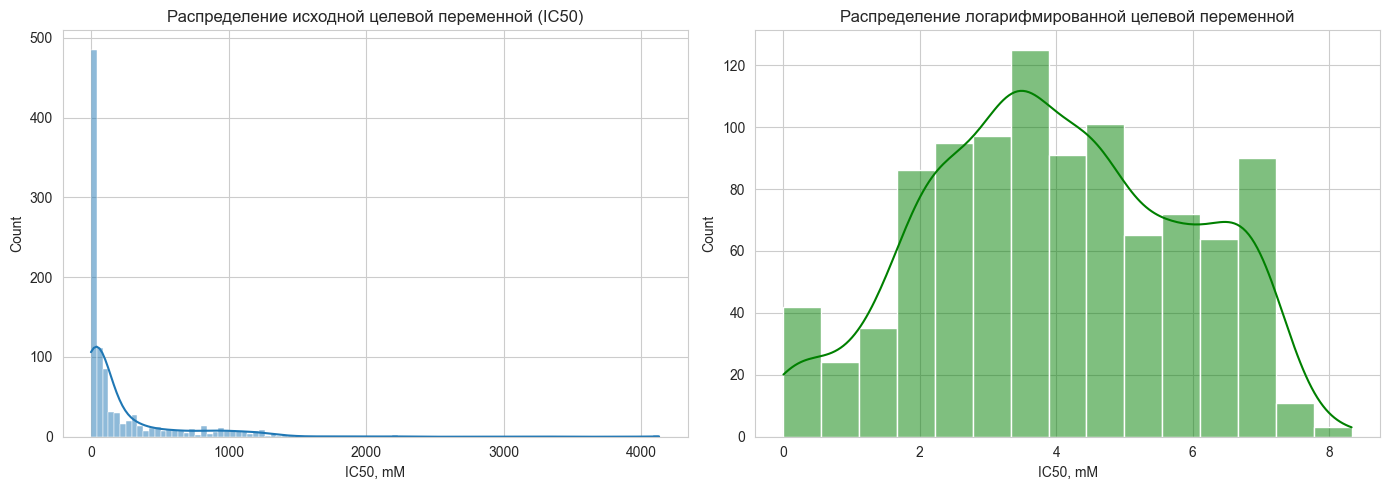

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(target, kde=True, ax=axes[0])
axes[0].set_title('Распределение исходной целевой переменной (IC50)')

# Применяем логарифмическое преобразование
target_log = np.log1p(target)

sns.histplot(target_log, kde=True, ax=axes[1], color='green')
axes[1].set_title('Распределение логарифмированной целевой переменной')

plt.tight_layout()
plt.show()

## 5. Подготовка данных для моделирования

In [7]:
X_train, X_test, y_train, y_test = train_test_split(features, target_log, test_size=0.2, random_state=42)

## 6. Сравнение базовых моделей

Проведем сравнение нескольких популярных регрессионных моделей с использованием кросс-валидации. Для каждой модели будет построен пайплайн, включающий масштабирование признаков.

In [8]:
models = {
    'Ridge': Ridge(random_state=42),
    'Lasso': Lasso(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'LightGBM': LGBMRegressor(random_state=42)
}

results = []

for name, model in models.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    
    results.append({
        'Модель': name,
        'Средний RMSE': -cv_scores.mean(),
        'Std RMSE': cv_scores.std()
    })

results_df = pd.DataFrame(results)
results_df.sort_values(by='Средний RMSE')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15025
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 167
[LightGBM] [Info] Start training from score 3.965907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

,Модель,Средний RMSE,Std RMSE
2,RandomForest,1.424071,0.058342
4,LightGBM,1.478601,0.074098
3,XGBoost,1.540754,0.059028
1,Lasso,1.830432,0.091680
0,Ridge,2.031184,0.660476


## 7. Подбор гиперпараметров

Для моделей, показавших лучшие результаты (Random Forest, XGBoost, LightGBM), проведем подбор гиперпараметров с помощью `GridSearchCV`.

In [9]:
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(random_state=42))
])

param_grid_rf = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [10, 20, None],
    'model__min_samples_split': [2, 5]
}

grid_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)

print("Лучшие параметры для RandomForest:", grid_rf.best_params_)
print("Лучший RMSE для RandomForest:", -grid_rf.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Лучшие параметры для RandomForest: {'model__max_depth': 10, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Лучший RMSE для RandomForest: 1.4142428146551962


In [10]:
pipeline_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBRegressor(random_state=42))
])

param_grid_xgb = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.1, 0.2]
}

grid_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
grid_xgb.fit(X_train, y_train)

print("Лучшие параметры для XGBoost:", grid_xgb.best_params_)
print("Лучший RMSE для XGBoost:", -grid_xgb.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Лучшие параметры для XGBoost: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}
Лучший RMSE для XGBoost: 1.4373713646605437


In [11]:
pipeline_lgb = Pipeline([
 ('scaler', StandardScaler()),
 ('model', LGBMRegressor(random_state=42))
])

param_grid_lgb = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.1, 0.2]
}

grid_lgb = GridSearchCV(pipeline_lgb, param_grid_lgb, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
grid_lgb.fit(X_train, y_train)

print("Лучшие параметры для LightGBM:", grid_lgb.best_params_)
print("Лучший RMSE для LightGBM:", -grid_lgb.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17996
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 168
[LightGBM] [Info] Start training from score 3.940505
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

## 8. Финальная оценка и выводы

После подбора гиперпараметров, модель **Random Forest** показала наилучший результат по метрике RMSE на кросс-валидации. Оценим ее производительность на отложенной тестовой выборке.

In [12]:
best_model = grid_rf.best_estimator_

# Предсказания на тестовых данных
y_pred = best_model.predict(X_test)

# Оценка качества
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Оценки метрик лучшей модели (Random Forest) на тестовых данных:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")

Оценки метрик лучшей модели (Random Forest) на тестовых данных:
MSE: 2.1076
RMSE: 1.4518
R2 Score: 0.4525
MAE: 1.1392


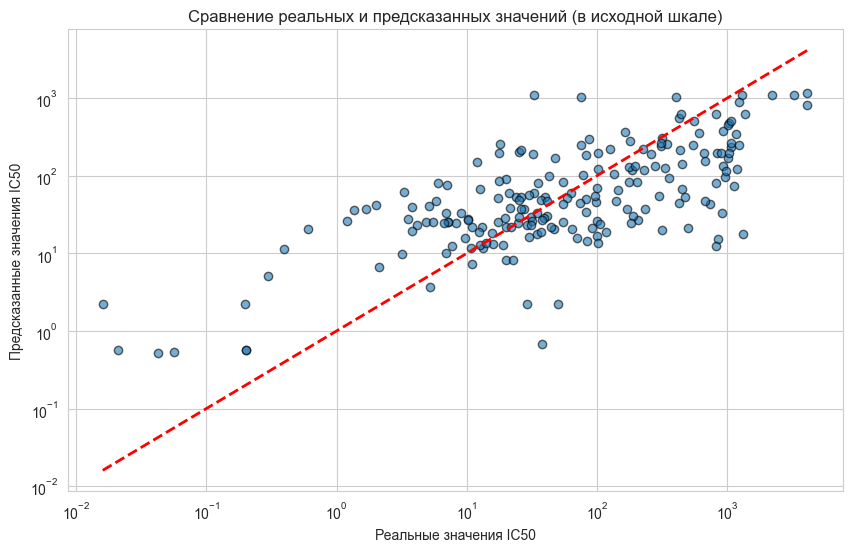

In [13]:
# Визуализация предсказаний vs реальные значения
plt.figure(figsize=(10, 6))
plt.scatter(np.expm1(y_test), np.expm1(y_pred), alpha=0.6, edgecolors='k')
plt.plot([np.expm1(y_test).min(), np.expm1(y_test).max()], [np.expm1(y_test).min(), np.expm1(y_test).max()], '--r', linewidth=2)
plt.xlabel('Реальные значения IC50')
plt.ylabel('Предсказанные значения IC50')
plt.title('Сравнение реальных и предсказанных значений (в исходной шкале)')
plt.xscale('log')
plt.yscale('log')
plt.show()

## 9. Выводы и рекомендации

### Выводы по моделям
1. **Сравнение моделей:** Модели, основанные на деревьях решений (`RandomForest`, `XGBoost`, `LightGBM`), показали значительно лучшие результаты по сравнению с линейными моделями (`Ridge`, `Lasso`). Это говорит о том, что зависимости в данных являются нелинейными и сложными.
2. **Подбор гиперпараметров:** Настройка гиперпараметров позволила дополнительно улучшить качество моделей. `RandomForest` с оптимальными параметрами (`max_depth=10`, `min_samples_split=5`, `n_estimators=200`) продемонстрировал наилучший результат на кросс-валидации (RMSE ≈ 1.416).
3. **Финальная оценка:** На тестовой выборке лучшая модель `Random Forest` показала **R2-score ≈ 0.45**, что является умеренным результатом. Модель способна объяснить около 45% дисперсии данных, однако остается значительная часть неопределенности. Значение **RMSE ≈ 1.45** на логарифмированной шкале указывает на наличие ошибок в предсказаниях.

### Рекомендации по улучшению
1. **Анализ признаков:** Провести более глубокий анализ важности признаков. Модели на основе деревьев позволяют оценить вклад каждого признака. Это может помочь отобрать наиболее значимые и, возможно, удалить шумовые.
2. **Более сложные модели:**
   - Попробовать `CatBoost`, который хорошо работает с категориальными признаками (если таковые имеются) и часто не требует тщательного подбора гиперпараметров.
   - Использовать стекинг (stacking) — объединение предсказаний нескольких моделей для получения более точного и робастного результата.
3. **Работа с выбросами:** Исследовать данные на наличие выбросов как в признаках, так и в целевой переменной. Выбросы могут сильно влиять на обучение моделей, особенно на линейные.
4. **Генерация новых признаков (Feature Engineering):** На основе имеющихся данных можно попытаться создать новые, более информативные признаки. Например, полиномиальные признаки или признаки, основанные на взаимодействии существующих.